In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
# nltk.download()

In [79]:
df = pd.read_csv(r'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [80]:
# remove NaN
dataAfter = df.dropna(subset=["reviews.rating"])

# convert the rating to integer
dataAfter["reviews.rating"] = dataAfter["reviews.rating"].astype(int)
df = dataAfter

In [81]:
import numpy as np

# implement sentiment analysis
analyser = SentimentIntensityAnalyzer()
def get_sentiment(text):
    sent = analyser.polarity_scores(text)
    max = np.max(sent)
    if sent['neg'] > sent['neu'] and sent['neg'] > sent['pos']:
        return "NEGATIVE"
    if sent['neu'] > sent['pos'] and sent['neu'] > sent['neg']:
        return "NEUTRAL"
    if sent['pos'] > sent['neu'] and sent['pos'] > sent['neg']:
        return "POSITIVE"
    # return np.array([sent['neg'], sent['neu'], sent['pos']])


df['reviews.sentiment'] = df['reviews.text'].apply(get_sentiment)
df['reviews.sent_text'] = df['reviews.sentiment'] + " " + df['reviews.text']


In [82]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

stop_words = set(stopwords.words('english'))
stop_words.add('review')
stop_words.add('that')

# to lowercase
df['reviews.text'] = df['reviews.text'].str.lower()

# Lemmatization
df['reviews.text'] = df['reviews.text'].apply(lemmatize_text)

# Remove stop words
df['reviews.text'] = df['reviews.text'].apply(lambda x: [item for item in x if item not in stop_words])

# Rejoing the words into a sentence
df['reviews.text'] = df['reviews.text'].str.join(' ')

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# print(df['reviews.sent_text'])

cv = CountVectorizer(binary=True)
cv.fit(df['reviews.text'])
X = cv.transform(df['reviews.text'])
# X = list(df['reviews.sentiment'])
y = df['reviews.rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [90]:
regressor = RandomForestClassifier(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [91]:
y_pred = regressor.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 115    1    3    3   75]
 [  14   47    2    8   55]
 [   2    8  133    9   92]
 [   1    0    3  691  433]
 [   8    1    4   59 3900]]
              precision    recall  f1-score   support

           1       0.82      0.58      0.68       197
           2       0.82      0.37      0.51       126
           3       0.92      0.55      0.68       244
           4       0.90      0.61      0.73      1128
           5       0.86      0.98      0.91      3972

    accuracy                           0.86      5667
   macro avg       0.86      0.62      0.70      5667
weighted avg       0.87      0.86      0.85      5667

0.8621845773778013


[[5.83756345e-01 5.07614213e-03 1.52284264e-02 1.52284264e-02
  3.80710660e-01]
 [1.11111111e-01 3.73015873e-01 1.58730159e-02 6.34920635e-02
  4.36507937e-01]
 [8.19672131e-03 3.27868852e-02 5.45081967e-01 3.68852459e-02
  3.77049180e-01]
 [8.86524823e-04 0.00000000e+00 2.65957447e-03 6.12588652e-01
  3.83865248e-01]
 [2.01409869e-03 2.51762336e-04 1.00704935e-03 1.48539778e-02
  9.81873112e-01]]


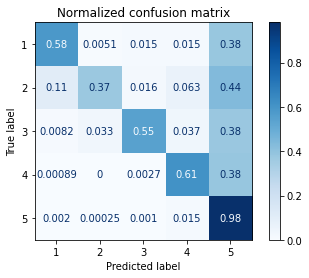

In [92]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(regressor, 
                            X_test, y_test,
                            display_labels=['1','2','3','4','5'],
                            cmap=plt.cm.Blues,
                            normalize='true')
disp.ax_.set_title('Normalized confusion matrix')
print(disp.confusion_matrix)

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

temp = df.sample(len(df))

cv = CountVectorizer(binary=True)
cv.fit(df['reviews.text'])
X = cv.transform(df['reviews.text'])
X_test = cv.transform(df['reviews.text'])

target = temp['reviews.rating']

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.6950444726810674
Accuracy for C=0.05: 0.6915148948185798


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy for C=0.25: 0.6817732599181138


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy for C=0.5: 0.6738670055061414
Accuracy for C=1: 0.662289990117182


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [57]:
final_model = LogisticRegression(C=0.01)
final_model.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))

feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}

Final Accuracy: 0.7025271777495412


In [58]:
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
   

('long', 0.09387525943899577)
('wireless', 0.09255086379381842)
('little', 0.08310696347342685)
('absolutely', 0.07523021392822175)
('got', 0.07504667843266634)


In [59]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('amazon', -0.11411212949811832)
('new', -0.10179833020812853)
('value', -0.0942535192165495)
('get', -0.08319806016135434)
('month', -0.0746227245035376)


In [60]:
df["reviews.rating"].value_counts()/len(df)   #percentage of ratings

5    0.702280
4    0.199351
3    0.042567
1    0.034060
2    0.021742
Name: reviews.rating, dtype: float64

In [61]:
reviews = df.copy()

In [62]:
reviews.groupby("asins")["name"].unique()

asins
B0002LCUZK,B010CEC6MI,B01B25NN64    [Expanding Accordion File Folder Plastic Porta...
B001NIZB5M                          [Amazon Kindle Replacement Power Adapter (Fits...
B005OOKNP4                          [AmazonBasics Bluetooth Keyboard for Android D...
B006BGZJJ4                          [Amazon Kindle Charger Power Adapter Wall Char...
B006GWO7UA                          [Kindle PowerFast International Charging Kit (...
                                                          ...                        
B06XD5YCKX                          [All-New Kindle Oasis E-reader - 7 High-Resolu...
B073SQYXTW                                               [Echo Spot Pair Kit (Black)]
B074MCBG25,B075357QFB               [Cat Litter Box Covered Tray Kitten Extra Larg...
B0751RGYJV                          [Amazon Echo (2nd Generation) Smart Assistant ...
B0752151W6                          [All-new Echo (2nd Generation) with improved s...
Name: name, Length: 65, dtype: object

In [63]:
%matplotlib inline 

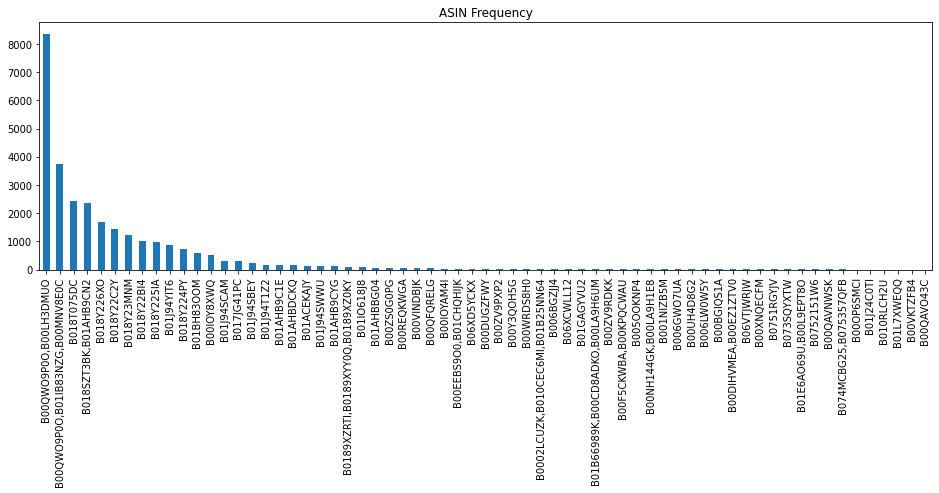

In [64]:
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(211)
#ax2 = plt.subplot(212, sharex = ax1)
reviews["asins"].value_counts().plot(kind="bar", ax=ax1, title="ASIN Frequency")

In [65]:
corr_matrix = reviews.corr()
corr_matrix
# Here we can analyze reviews.ratings with asins

,reviews.id,reviews.numHelpful,reviews.rating
reviews.id,1.000000,-0.553529,0.074941
reviews.numHelpful,-0.553529,1.000000,-0.041006
reviews.rating,0.074941,-0.041006,1.000000


In [66]:
counts = reviews["asins"].value_counts().to_frame()
counts.head()

,asins
"B00QWO9P0O,B00LH3DMUO",8343
"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",3728
B018T075DC,2443
"B018SZT3BK,B01AHB9CN2",2370
B018Y226XO,1676


In [67]:
avg_rating = reviews.groupby("asins")["reviews.rating"].mean().to_frame()
avg_rating.head()

,reviews.rating
asins,
"B0002LCUZK,B010CEC6MI,B01B25NN64",5.000000
B001NIZB5M,2.800000
B005OOKNP4,4.333333
B006BGZJJ4,4.666667
B006GWO7UA,4.800000


In [68]:
table = counts.join(avg_rating)
table.head(30)

,asins,reviews.rating
"B00QWO9P0O,B00LH3DMUO",8343,4.448040
"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",3728,4.453594
B018T075DC,2443,4.597217
"B018SZT3BK,B01AHB9CN2",2370,4.584388
B018Y226XO,1676,4.531026
B018Y22C2Y,1425,4.534035
B018Y23MNM,1212,4.534653
B018Y22BI4,1024,4.506836
B018Y225IA,987,4.511651
B01J94YIT6,883,4.578709


,asins,reviews.rating
asins,1.000000,0.021024
reviews.rating,0.021024,1.000000


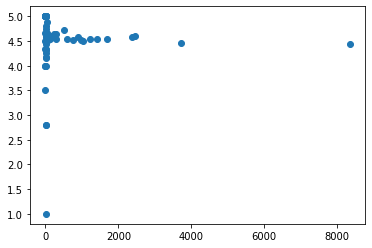

In [69]:
plt.scatter("asins", "reviews.rating", data=table)
table.corr()
